In [1]:
import numpy as np
import mlrose_hiive as mlrose
import time
import matplotlib.pyplot as plt
import pandas as pd

## 1. Optimization Problems

In [31]:
def choose_fitness_func(problem_type, size):
    if problem_type == "FourPeaks":
        fitness = mlrose.FourPeaks(t_pct=0.5)
    elif problem_type == "OneMax":
        fitness = mlrose.OneMax()
    elif problem_type == "FlipFlop":
        fitness = mlrose.FlipFlop()
    elif problem_type == "Knapsack":
        weights= np.random.uniform(low=0.1, high=1, size=(size,))
        values= np.random.uniform(low=1, high=size, size=(size,))
        fitness = mlrose.Knapsack(weights, values)
    elif problem_type == "TravellingSalesMan":
        coords_list = [(1, 1), (4, 2), (5, 2), (6, 4), (4, 4), (3, 6), (1, 5), (2, 3)]
        fitness = mlrose.TravellingSales(coords=coords_list)
    else:
        problem_type = "ContinuousPeaks"
        fitness = mlrose.ContinuousPeaks(t_pct=0.15)
    return fitness

def opt_problem_from_fitness(fitness, size, problem_name):
    if problem_name == "TravellingSalesMan":
        return mlrose.TSPOpt(length = 8, fitness_fn = fitness, maximize=False)
    return mlrose.DiscreteOpt(length=size, fitness_fn=fitness, maximize=True, max_val=2)

In [32]:
def run_optimization_experiment(sizes_for_exps, problem_type):
    
    rhc_results=[]
    ga_results=[]
    sa_results=[]
    mimic_results=[]
    
    for each_size in sizes_for_exps:

        # Get the Fitness Function
        fitness_fn = choose_fitness_func(problem_type, each_size)
        opt_problem = opt_problem_from_fitness(fitness_fn, each_size, problem_type)
        
        max_iters = each_size*10
        max_attempts = 10
        curve = True
        init_state = None
        # 1. Random Hill Climb Optimization
        start_time = time.time()
        rhc_results_iter = mlrose.random_hill_climb(opt_problem, restarts=10*each_size, max_attempts = max_attempts, max_iters = max_iters, curve = curve, 
                                              init_state=None)
        end_time = time.time()

        rhc_results.append([each_size,end_time-start_time,rhc_results_iter[2][-1,0],rhc_results_iter[2][-1,1],rhc_results_iter[2][-1,1]/(end_time-start_time)])

        # 2. Genetic Algorithm
        start_time = time.time()
        ga_results_iter = mlrose.genetic_alg(opt_problem, pop_size=10*each_size, mutation_prob=0.4 , max_attempts = max_attempts, max_iters = max_iters, curve = curve)
        end_time = time.time()

        ga_results.append([each_size,end_time-start_time,ga_results_iter[2][-1,0],ga_results_iter[2][-1,1],ga_results_iter[2][-1,1]/(end_time-start_time)])

        
        # 3. Simulated Annealing
        start_time = time.time()
        sa_results_iter = mlrose.simulated_annealing(opt_problem, schedule=mlrose.GeomDecay() , max_attempts = max_attempts, max_iters = max_iters, curve = curve,
                                               init_state=None)
        end_time = time.time()
        sa_results.append([each_size,end_time-start_time,sa_results_iter[2][-1,0],sa_results_iter[2][-1,1],sa_results_iter[2][-1,1]/(end_time-start_time)])
        
        # 4. MIMIC
        start_time = time.time()
        mimic_results_iter = mlrose.mimic(opt_problem, pop_size=10*each_size , max_attempts = max_attempts, max_iters = max_iters, curve = curve)
        end_time = time.time()
    
        mimic_results.append([each_size,end_time-start_time,mimic_results_iter[2][-1,0],mimic_results_iter[2][-1,1],mimic_results_iter[2][-1,1]/(end_time-start_time)])
    print ("Completed")
    return [rhc_results, ga_results, sa_results, mimic_results], [rhc_results_iter, ga_results_iter, sa_results_iter, mimic_results_iter]

In [4]:
sizes_for_exps = range(10,100,10)

fourpeaks_results, fourpeaks_results_iter = run_optimization_experiment(sizes_for_exps, problem_type = "FourPeaks")
oneMax_results, oneMax_results_iter = run_optimization_experiment(sizes_for_exps, problem_type = "OneMax")
flipflop_results, flipflop_results_iter = run_optimization_experiment(sizes_for_exps, problem_type = "FlipFlop")
knapsack_results, knapsack_results_iter = run_optimization_experiment(sizes_for_exps, problem_type = "Knapsack")
contpeaks_results, contpeaks_results_iter = run_optimization_experiment(sizes_for_exps, problem_type = "ContinuousPeaks")

Completed
Completed
Completed
Completed
Completed


In [33]:
travelsales_results, travelsales_results_iter = run_optimization_experiment(sizes_for_exps, problem_type = "TravellingSalesMan")

Completed


In [5]:
ALGO = ['RHC','GA','SA','MIMIC']

In [6]:
feature_mapping = {0: "Problem Size",
                   1: "Clock Time",
                   2: "Best Fitness Values",
                   3: "Number of Evaluations",
                   4: "Number of Evaluations per sec",
                   5: "All Fitness Values"}

In [7]:
def plot_feature(feature_idx, results, problem_name):

    feature_name = feature_mapping[feature_idx]
    print (feature_name)
    df = pd.DataFrame()
    
    for i,each_algo in enumerate(ALGO):
        df_sub = pd.DataFrame(results[i])[feature_idx]
        df = pd.concat([df, df_sub], axis=1)
    
    df.columns=[ALGO]
    df.plot(marker="o")
    plt.xlabel(feature_mapping[0])
    plt.ylabel(feature_name)
    title_name = f"{problem_name} - {feature_name} vs {feature_mapping[0]}"
    plt.title(title_name)
    plt.savefig(f"images/{title_name}")

In [8]:
def plot_intermediate_feature(feature_idx, results_iter, problem_name):

    feature_name = feature_mapping[feature_idx]
    print (feature_name)
    df = pd.DataFrame()
    
    for i,each_algo in enumerate(ALGO):
        df_sub = pd.DataFrame(results_iter[i][2][:,0])
        df = pd.concat([df, df_sub], axis=1)
    df.columns=[ALGO]
    df.plot(marker="o")
    plt.xlabel("Iterations")
    plt.ylabel(feature_name)
    title_name = f"{problem_name} - {feature_name} vs Iterations"
    plt.title(title_name)
    plt.savefig(f"images/{title_name}")

## 1. FourPeaks Analysis

Clock Time
Best Fitness Values
Number of Evaluations
Number of Evaluations per sec


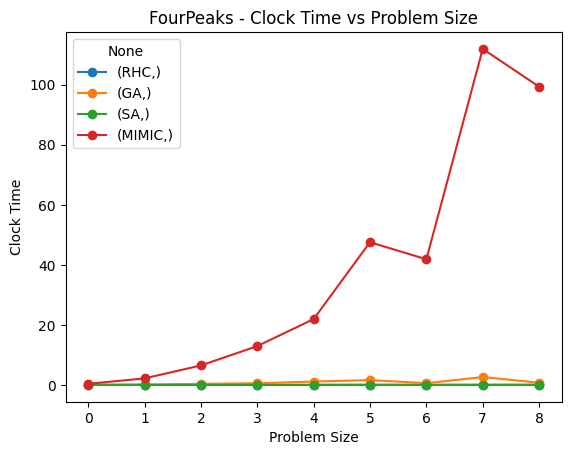

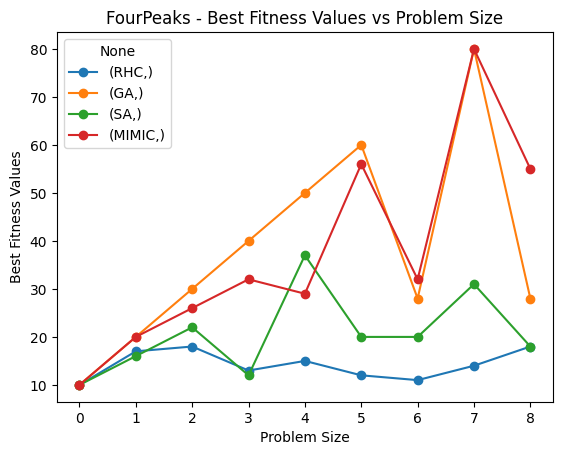

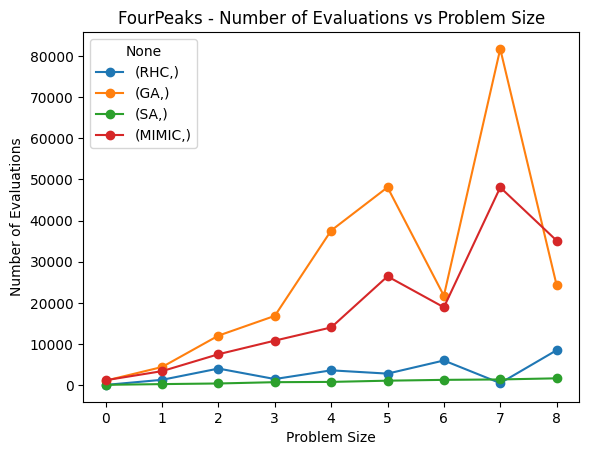

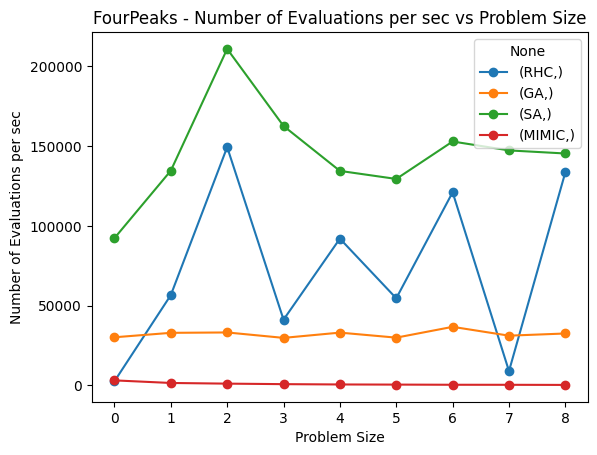

In [9]:
for i in range(1,5):
    plot_feature(i, fourpeaks_results, "FourPeaks")

All Fitness Values


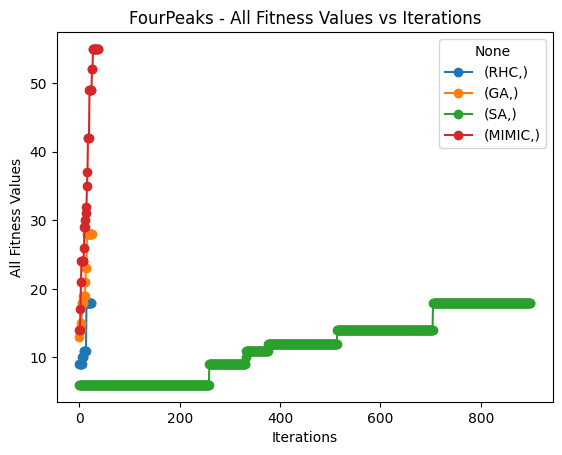

In [10]:
plot_intermediate_feature(5, fourpeaks_results_iter, "FourPeaks")

## 2. One-Max Results

Clock Time
Best Fitness Values
Number of Evaluations
Number of Evaluations per sec


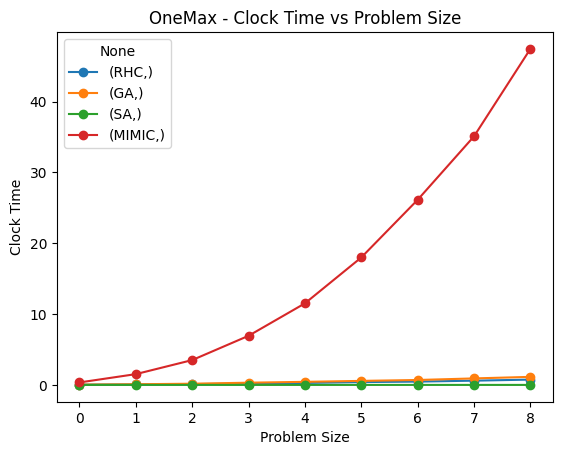

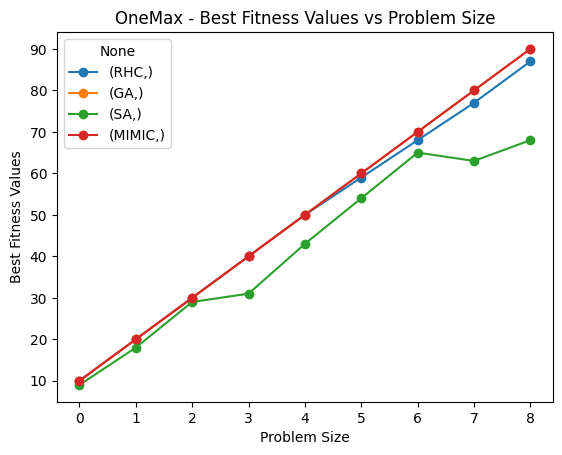

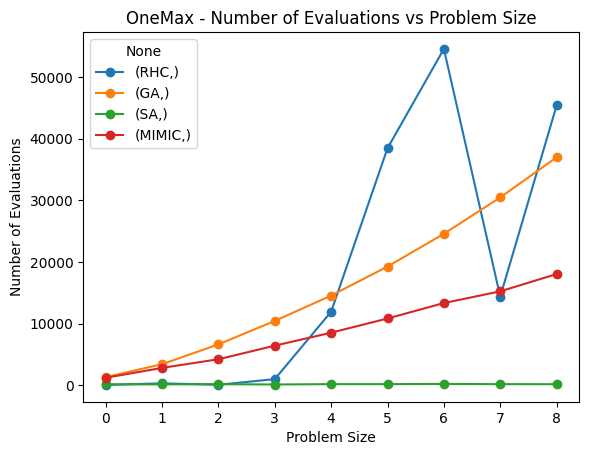

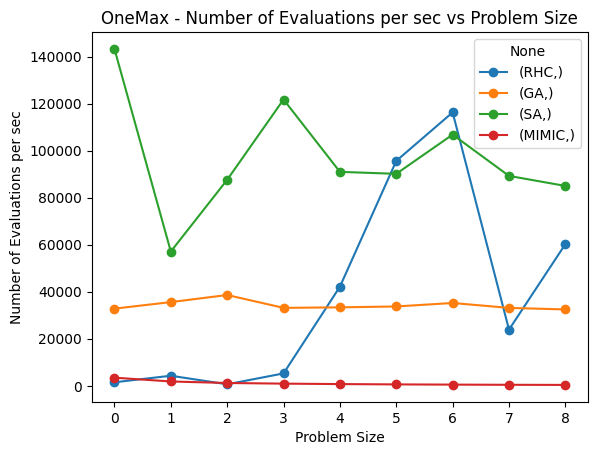

In [11]:
for i in range(1,5):
    plot_feature(i, oneMax_results, "OneMax")

All Fitness Values


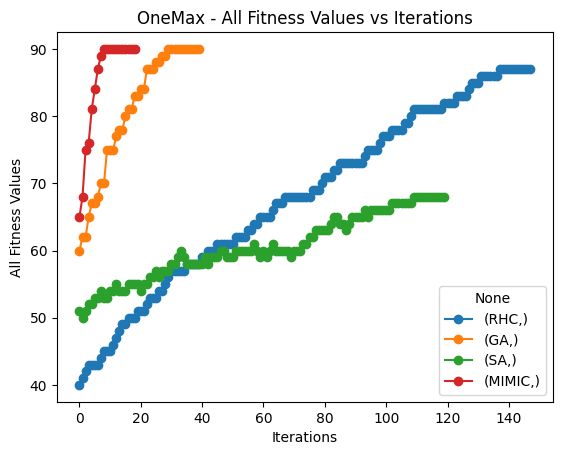

In [12]:
plot_intermediate_feature(5, oneMax_results_iter, "OneMax")

### 3. Knapsack results

Clock Time
Best Fitness Values
Number of Evaluations
Number of Evaluations per sec


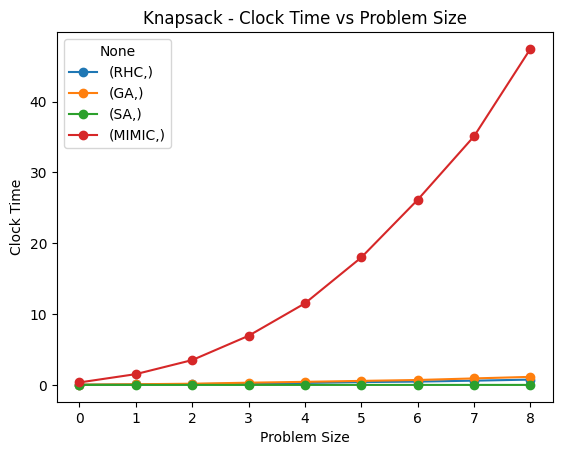

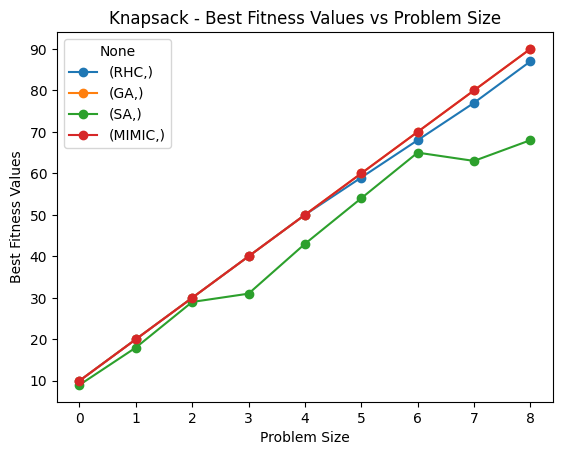

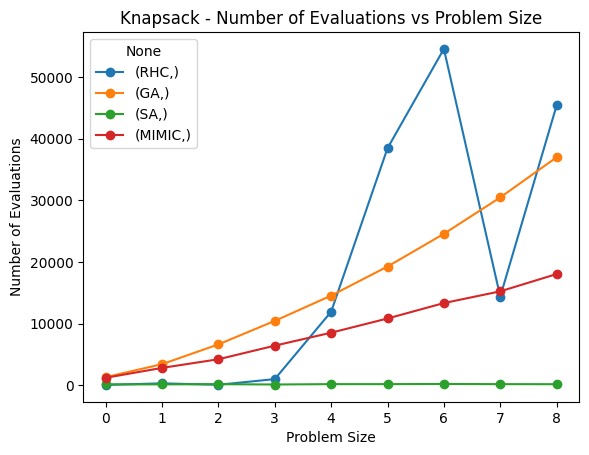

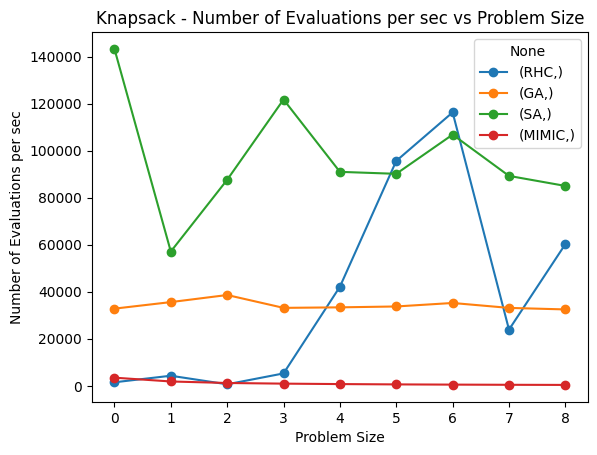

In [13]:
for i in range(1,5):
    plot_feature(i, oneMax_results, "Knapsack")

All Fitness Values


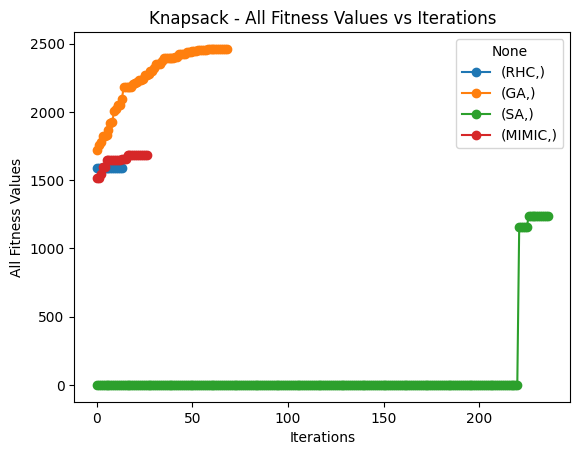

In [14]:
plot_intermediate_feature(5, knapsack_results_iter, "Knapsack")

### 4. FlipFlop results

Clock Time
Best Fitness Values
Number of Evaluations
Number of Evaluations per sec


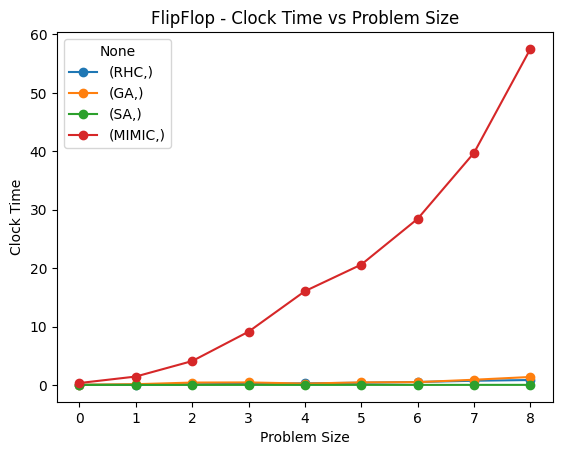

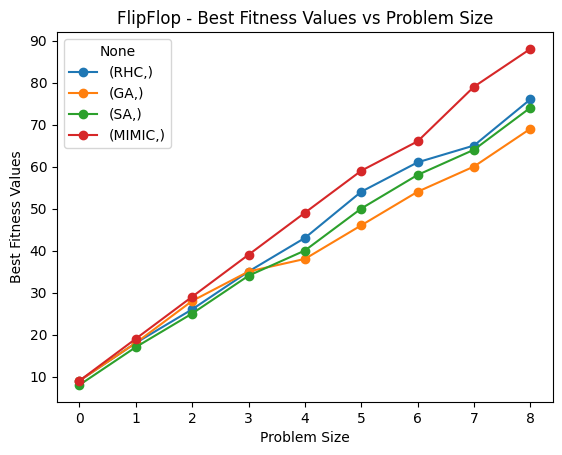

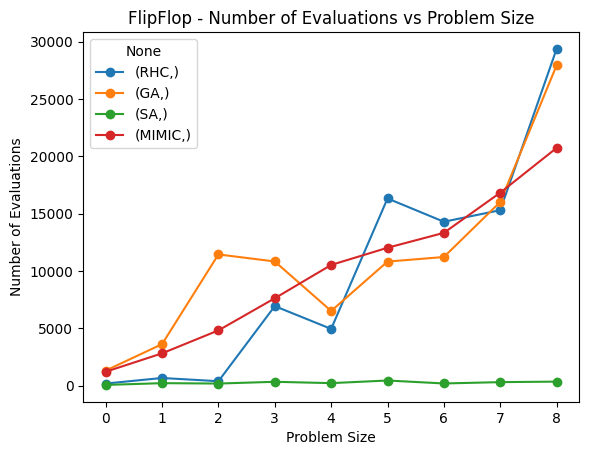

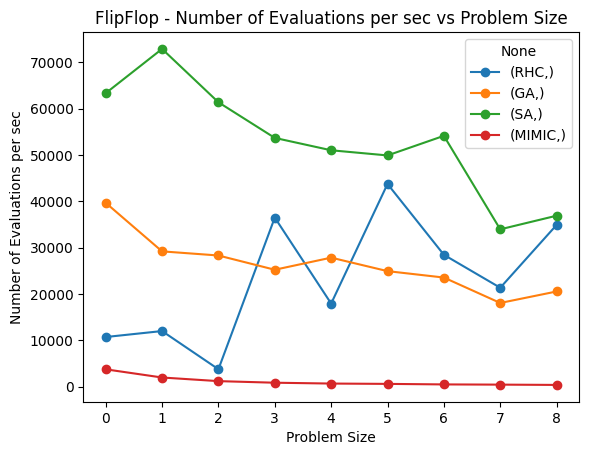

In [15]:
for i in range(1,5):
    plot_feature(i, flipflop_results, "FlipFlop")

All Fitness Values


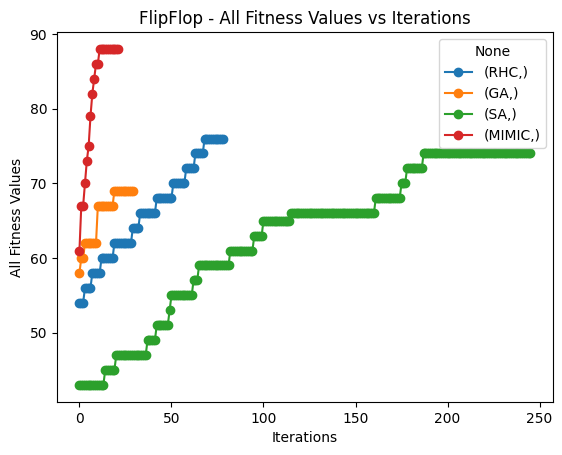

In [16]:
plot_intermediate_feature(5, flipflop_results_iter, "FlipFlop")

### 5. Continuous Peaks

Clock Time
Best Fitness Values
Number of Evaluations
Number of Evaluations per sec


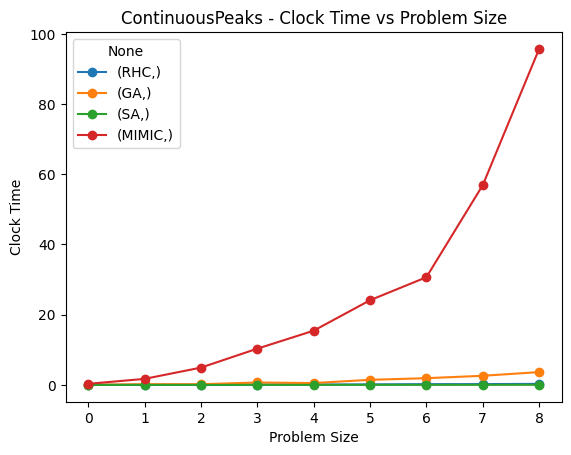

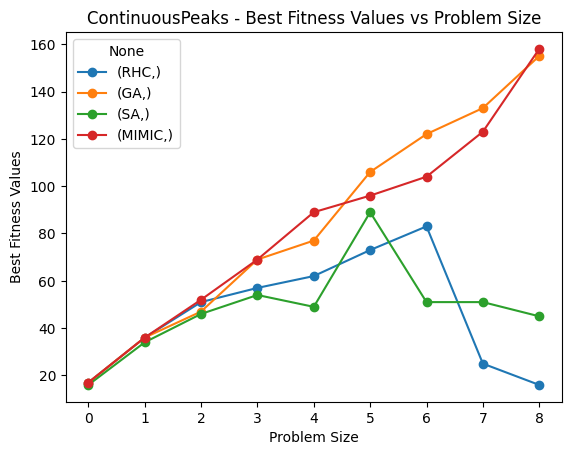

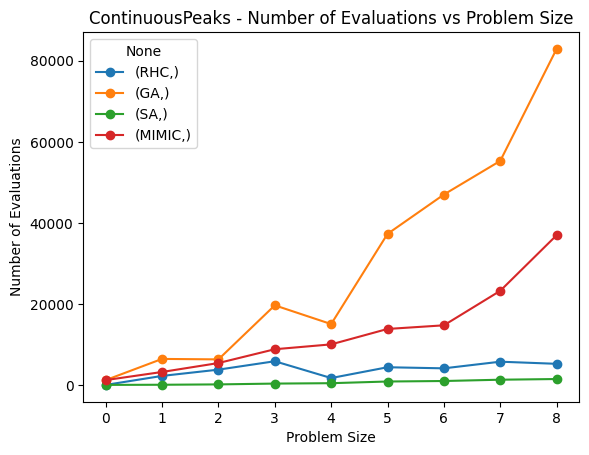

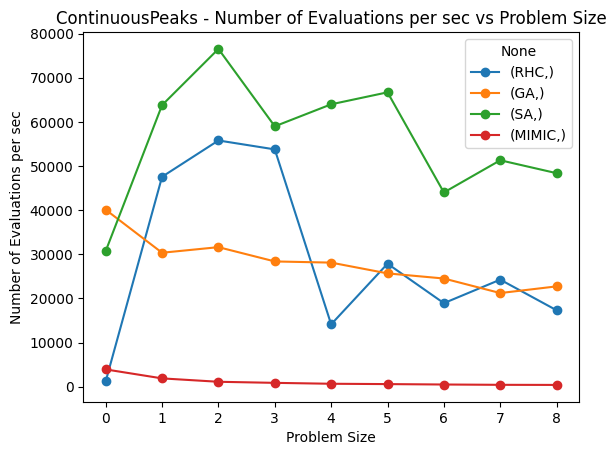

In [17]:
for i in range(1,5):
    plot_feature(i, contpeaks_results, "ContinuousPeaks")

All Fitness Values


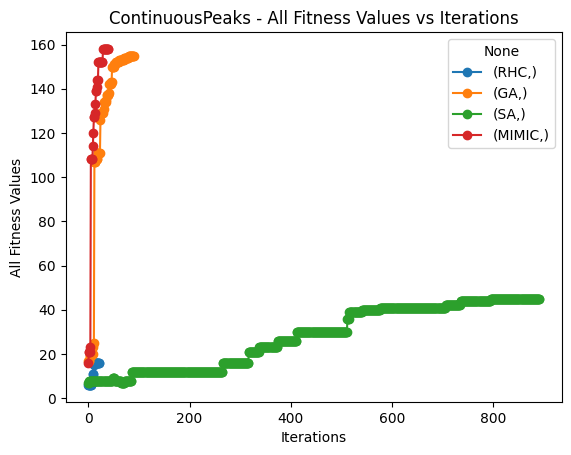

In [18]:
plot_intermediate_feature(5, contpeaks_results_iter, "ContinuousPeaks")

# 6. Travelling SalesMan

Clock Time
Best Fitness Values
Number of Evaluations
Number of Evaluations per sec


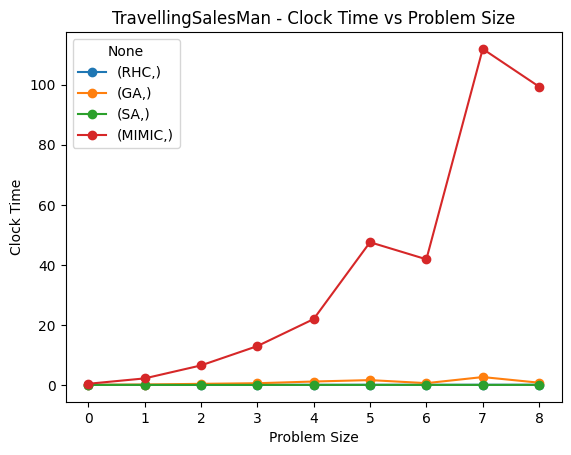

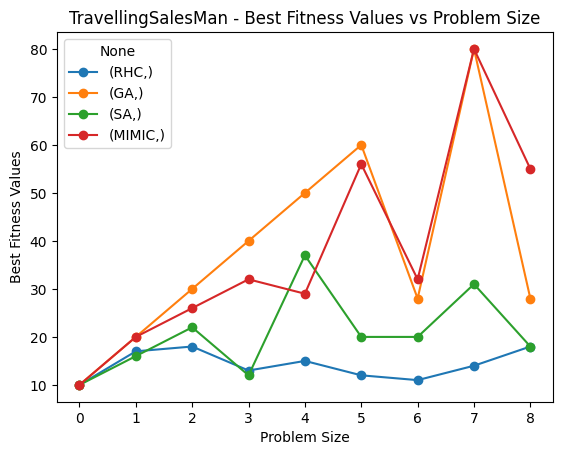

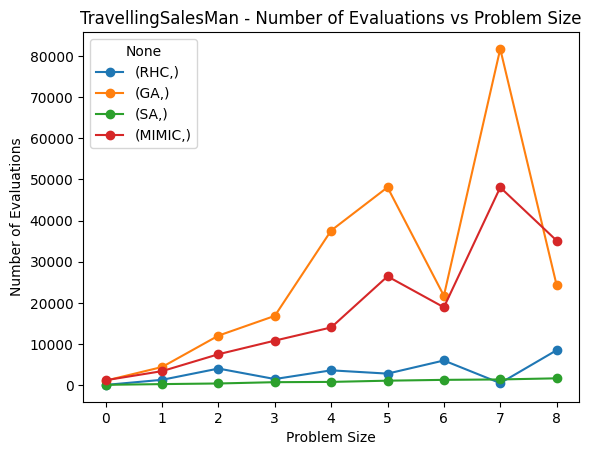

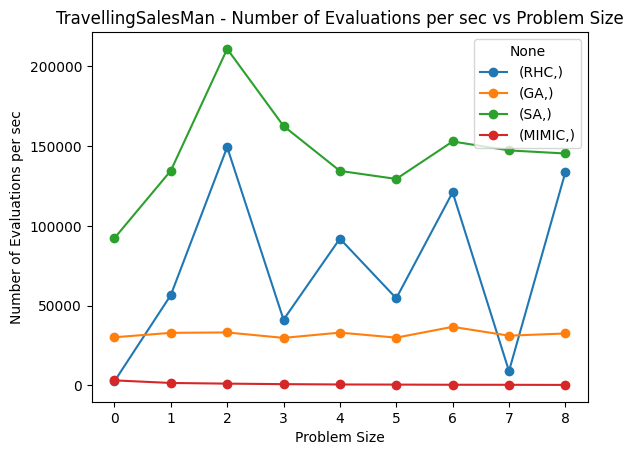

In [34]:
for i in range(1,5):
    plot_feature(i, fourpeaks_results, "TravellingSalesMan")

All Fitness Values


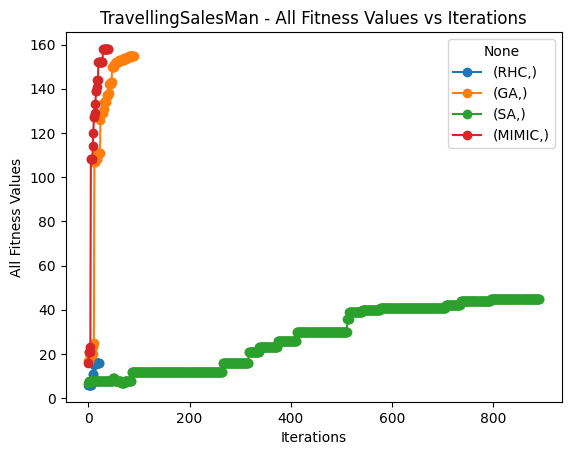

In [35]:
plot_intermediate_feature(5, contpeaks_results_iter, "TravellingSalesMan")